---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 3**: Improving Lexical Search

### 📅 **Due Date**: Day of Lecture 4, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

You'll apply what we covered in Lecture 3 (Lexical Search & BM25) to a real e-commerce search problem using the **WANDS dataset** 
- WANDS stands for Wayfair Annotated Dataset. It's a dataset of furniture products and search queries, along with human relevance judgments.

You will:
1. **Build a search engine** from scratch using BM25.
2. **Learn how to evaluate search results** using NDCG — a metric for measuring search quality
3. **Attempt to improve your search engine** by adding multiple fields
4. **Use LLMs to improve your search engine** by adding simple query understanding

Yes, *you* will do all these things. Let's go!

---

## Task 1: Environment Setup

First, let's set up your environment and verify everything works.

### 1a. Install dependencies and verify imports

Run `uv add pystemmer` in your terminal to add the Snowball stemmer. Then run the cell below to verify all imports work.

In [2]:
# Task 1a: Verify imports work
import pandas as pd
import numpy as np
from collections import Counter
import string
from pathlib import Path
# a stemmer from `pystemmer` for better tokenization
import Stemmer 
# llm packages
import litellm
from pydantic import BaseModel, Field
from typing import Optional
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Pandas display settings
# pd.set_option('display.max_colwidth', 100)

# Ignore pydantic warnings for litellm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

print("All imports successful!")

All imports successful!


### 1b. Verify API keys

Test that your API keys work by making a simple call.

In [3]:
# Task 1b: Verify API keys
response = litellm.completion(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=20
)
print(response.choices[0].message.content)

API working!


---

## Task 2: Load and Explore the WANDS Dataset

The **WANDS dataset** (Wayfair Annotated Dataset) contains:
- 43K furniture products from Wayfair
- 480 real search queries
- 233K human relevance judgments (query-product pairs)

This is a real-world search benchmark used to evaluate e-commerce search systems!

**Data Source**: [WANDS on GitHub](https://github.com/wayfair/WANDS)

The data files are pre-downloaded in the `data/` directory:
- `wayfair-products.csv` - Product catalog
- `wayfair-queries.csv` - Search queries
- `wayfair-labels.csv` - Relevance judgments

### Data Loading Functions (provided)

Run the cell below to define the loading functions.

In [6]:
# Data loading functions (provided)
# Note: Data from WANDS (Wayfair Annotated Dataset)
# Source: https://github.com/wayfair/WANDS

def load_wands_products(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS products from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-products.csv
        
    Returns:
        DataFrame with product information including product_id, product_name,
        product_class, category_hierarchy, product_description, etc.
    """
    filepath = Path(data_dir) / "wayfair-products.csv"
    products = pd.read_csv(filepath, sep='\t')
    products = products.rename(columns={'category hierarchy': 'category_hierarchy'})
    return products

def load_wands_queries(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS queries from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-queries.csv
        
    Returns:
        DataFrame with query_id and query columns
    """
    filepath = Path(data_dir) / "wayfair-queries.csv"
    queries = pd.read_csv(filepath, sep='\t')
    return queries

def load_wands_labels(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS relevance labels from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-labels.csv
        
    Returns:
        DataFrame with query_id, product_id, label (Exact/Partial/Irrelevant),
        and grade (2/1/0) columns
    """
    filepath = Path(data_dir) / "wayfair-labels.csv"
    labels = pd.read_csv(filepath, sep='\t')
    grade_map = {'Exact': 2, 'Partial': 1, 'Irrelevant': 0}
    labels['grade'] = labels['label'].map(grade_map)
    return labels

print("Loading functions defined!")

Loading functions defined!


### 2a. Load the data

Use the provided functions to load all three datasets. Print the number of rows in each.

In [7]:
# Task 2a: Load the data

# Use "../data" when notebook is in homeworks/ (default in loading functions)
data_dir = "../data"
products = load_wands_products(data_dir)
queries = load_wands_queries(data_dir)
labels = load_wands_labels(data_dir)

# Print the number of rows in each
print(f"Products: {len(products):,} rows")
print(f"Queries:  {len(queries):,} rows")
print(f"Labels:   {len(labels):,} rows")


Products: 42,994 rows
Queries:  480 rows
Labels:   233,448 rows


### 2b. Explore products

List the available columns, and display a few sample products. 

Which columns might be useful for search?

In [ ]:
# List available columns
print("Columns in products:")
print(products.columns.tolist())

# Display a few sample products
print("\nSample products (first 3):")
display(products.head(3))

# product_name, product_description, product_features, and category_hierarchy


Columns in products:
['product_id', 'product_name', 'product_class', 'category_hierarchy', 'product_description', 'product_features', 'rating_count', 'average_rating', 'review_count']

Sample products (first 3):


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0


In [12]:
# YOUR CODE HERE
# List available columns
print("Columns in labels:")
print(labels.columns.tolist())

# Display a few sample products
print("\nSample labels (first 3):")
display(labels.head(3))

Columns in labels:
['id', 'query_id', 'product_id', 'label', 'grade']

Sample labels (first 3):


,id,query_id,product_id,label,grade
0,0,0,25434,Exact,2
1,1,0,12088,Irrelevant,0
2,2,0,42931,Exact,2


In [11]:
# YOUR CODE HERE
# List available columns
print("Columns in queries:")
print(queries.columns.tolist())

# Display a few sample products
print("\nSample queries (first 3):")
display(queries.head(3))

Columns in queries:
['query_id', 'query', 'query_class']

Sample queries (first 3):


,query_id,query,query_class
0,0,salon chair,Massage Chairs
1,1,smart coffee table,Coffee & Cocktail Tables
2,2,dinosaur,Kids Wall Décor


### 2c. Understand relevance judgments

The `labels` dataset contains human judgments of relevance. In particular, for each query-product pair, it contains:
| Label        | Grade | Description                                 |
|--------------|-------|---------------------------------------------|
| Exact        |   2   | This product is exactly what the user wants |
| Partial      |   1   | This product is somewhat relevant           |
| Irrelevant   |   0   | This product doesn't match the query        |

First, let's look at the distribution of grades.

In [13]:
# Task 2c: Understand judgments

# Distribution of grades (0=Irrelevant, 1=Partial, 2=Exact)
grade_dist = labels["grade"].value_counts().sort_index()
print("Distribution of relevance grades:")
print(grade_dist)
print(f"\nAs percentages:")
print((grade_dist / len(labels) * 100).round(1).astype(str) + "%")


Distribution of relevance grades:
grade
0     61201
1    146633
2     25614
Name: count, dtype: int64

As percentages:
grade
0    26.2%
1    62.8%
2    11.0%
Name: count, dtype: str


---
## Task 3: Build and Run BM25 Search

Now let's build a BM25 search engine! We'll use the same concepts from Lecture 3.

### Provided Functions

We're giving you these functions to work with. Run the next cell to define them, then look at the examples.

| Function | What it does |
|----------|--------------|
| `snowball_tokenize(text)` | Tokenizes text, removes punctuation, stems words |
| `build_index(docs, tokenizer)` | Builds an inverted index from a list of documents |
| `get_tf(term, doc_id, index)` | Gets term frequency for a term in a document |
| `get_df(term, index)` | Gets document frequency for a term (how many docs contain the term) |
| `bm25_idf(df, num_docs)` | Calculates the IDF component of BM25 |
| `bm25_tf(tf, doc_len, avg_doc_len)` | Calculates the TF normalization for BM25 |
| `score_bm25(query, index, ...)` | Scores all documents for a query using BM25 |
| `search_products(query, ...)` | Searches and returns top-k results |

In [14]:
# Provided functions - run this cell to define them

stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    """
    Tokenize text with Snowball stemming.
    
    Args:
        text: The text to tokenize
        
    Returns:
        List of stemmed tokens
    """
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """
    Build an inverted index from a list of documents.
    
    Args:
        docs: List of document strings to index
        tokenizer: Function that takes text and returns list of tokens
        
    Returns:
        index: dict mapping term -> {doc_id: term_count}
        doc_lengths: list of document lengths (in tokens)
    """
    index = {}
    doc_lengths = []
    
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    
    return index, doc_lengths

def get_tf(term: str, doc_id: int, index: dict) -> int:
    """
    Get term frequency for a term in a document.
    
    Args:
        term: The term to look up
        doc_id: The document ID
        index: The inverted index
        
    Returns:
        Term frequency (count), or 0 if not found
    """
    if term in index and doc_id in index[term]:
        return index[term][doc_id]
    return 0

def get_df(term: str, index: dict) -> int:
    """
    Get document frequency for a term.
    
    Args:
        term: The term to look up
        index: The inverted index
        
    Returns:
        Number of documents containing the term
    """
    if term in index:
        return len(index[term])
    return 0

def bm25_idf(df: int, num_docs: int) -> float:
    """
    BM25 IDF formula.
    
    Args:
        df: Document frequency
        num_docs: Total number of documents
        
    Returns:
        IDF score
    """
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    """
    BM25 TF normalization.
    
    Args:
        tf: Term frequency
        doc_len: Document length in tokens
        avg_doc_len: Average document length
        k1: Saturation parameter (default 1.2)
        b: Length normalization (default 0.75)
        
    Returns:
        Normalized TF score
    """
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """
    Score all documents using BM25.
    
    Args:
        query: The search query
        index: Inverted index
        num_docs: Total number of documents
        doc_lengths: List of document lengths
        tokenizer: Tokenization function
        
    Returns:
        Array of scores for each document
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue
        
        idf = bm25_idf(df, num_docs)
        
        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    
    return scores

def search_products(query: str, products_df: pd.DataFrame, index: dict, 
                    doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    """
    Search products and return top-k results.
    
    Args:
        query: The search query
        products_df: DataFrame of products
        index: Inverted index
        doc_lengths: Document lengths
        tokenizer: Tokenization function
        k: Number of results to return
        
    Returns:
        DataFrame with top-k products and scores
    """
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

print("All functions defined!")

All functions defined!


In [15]:
# Examples of each function

# 1. snowball_tokenize - tokenizes and stems text
print("1. snowball_tokenize('Running shoes are amazing!')")
print(f"   -> {snowball_tokenize('Running shoes are amazing!')}")
print("   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'")

# 2. build_index - builds inverted index (we'll use a tiny example)
tiny_docs = ["red shoe", "blue shoe", "red hat"]
tiny_index, tiny_lengths = build_index(tiny_docs, snowball_tokenize)
print("\n2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)")
print(f"   Index: {tiny_index}")
print(f"   Lengths: {tiny_lengths}")

# 3. get_tf - get term frequency
print("\n3. get_tf('red', doc_id=0, tiny_index)")
print(f"   -> {get_tf('red', 0, tiny_index)}  (doc 0 = 'red shoe' has 1 'red')")

# 4. get_df - get document frequency  
print("\n4. get_df('red', tiny_index)")
print(f"   -> {get_df('red', tiny_index)}  ('red' appears in 2 documents)")

# 5. bm25_idf - calculate IDF (rare terms get higher scores)
print("\n5. bm25_idf(df=100, num_docs=10000)")
print(f"   -> {bm25_idf(100, 10000):.4f}  (term in 100 of 10000 docs)")

# 6. bm25_tf - normalize term frequency by document length
print("\n6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)")
print(f"   -> {bm25_tf(3, 50, 100):.4f}  (short doc gets boosted)")

# 7-8. score_bm25 and search_products - we'll use these next!
print("\nWe'll use score_bm25() and search_products() in Task 3a!")

1. snowball_tokenize('Running shoes are amazing!')
   -> ['run', 'shoe', 'are', 'amaz']
   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'

2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)
   Index: {'red': {0: 1, 2: 1}, 'shoe': {0: 1, 1: 1}, 'blue': {1: 1}, 'hat': {2: 1}}
   Lengths: [2, 2, 2]

3. get_tf('red', doc_id=0, tiny_index)
   -> 1  (doc 0 = 'red shoe' has 1 'red')

4. get_df('red', tiny_index)
   -> 2  ('red' appears in 2 documents)

5. bm25_idf(df=100, num_docs=10000)
   -> 4.6003  (term in 100 of 10000 docs)

6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)
   -> 1.7600  (short doc gets boosted)

We'll use score_bm25() and search_products() in Task 3a!


### 3a. Create BM25 index for product_name

Build an inverted index for the `product_name` field and run a sample search for a product.

In [24]:
# Task 3a: Create BM25 index for product_name

# 1. Get documents (one per product) from product_name
docs_name = products["product_name"].fillna("").astype(str).tolist()

# 2. Build inverted index and document lengths
index_name, doc_lengths_name = build_index(docs_name, snowball_tokenize)
num_docs = len(products)

# 3. Run a sample search
sample_query = "coffee table"
results = search_products(sample_query, products, index_name, doc_lengths_name, snowball_tokenize)
results


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score,rank
33290,33290,coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,NaN,topmaterialdetails : semolina in combination w...,NaN,NaN,NaN,7.812564,1
20513,20513,coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,when it comes to rounding out your seating ens...,estimatedtimetoassembleinternal:100|basecolor ...,42.0,4.5,24.0,7.812564,2
22679,22679,coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,this amazing coffee table with oval tempered g...,overallproductweight:106|overallheight-toptobo...,8.0,5.0,6.0,7.812564,3
608,608,coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,disclaimer : the product in the photo is an ex...,topmaterial : glass|basematerial : solid wood|...,NaN,NaN,NaN,7.812564,4
5173,5173,coffee table,Patio Tables,Outdoor / Outdoor & Patio Furniture / Outdoor ...,introduce a subtle style to your place with th...,outerframemetaltype : aluminum|overallheight-t...,NaN,NaN,NaN,7.812564,5
19750,19750,"a-37 coffee table in , matching coffee table",Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,NaN,basecolor : gold|overalldepth-fronttoback:47.2...,NaN,NaN,NaN,7.236303,6
24638,24638,lovins coffee table,Coffee & Cocktail Tables,Sale / Closeout / Coffee Tables / Rectangle Co...,is the seating ensemble feeling empty ? try a ...,basecolor : gray|additionaltoolsrequirednotinc...,39.0,4.5,32.0,7.184479,7
19212,19212,ashwood coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,"this modular coffee table is a perfect oval , ...",additionaltoolsrequirednotincluded : all tools...,312.0,4.5,208.0,7.184479,8
4599,4599,petrus coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,this unique geometric table features a low pro...,basetype : abstract|overalllength-endtoend:48|...,109.0,4.5,95.0,7.184479,9
4250,4250,drum coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,the product offers high-design furniture with ...,basetype : drum|topmaterial : concrete|levelof...,17.0,4.0,16.0,7.184479,10


### 3b. Add product_description to search

Create a second index for `product_description` and combine scores from both fields.

**Hint**: You can combine the two scores by adding them together. This is like multi-field search from Lecture 3.

In [25]:
# Task 3b: Add product_description to search

# 1. Build index for product_description (reuse index_name from 3a for product_name)
docs_desc = products["product_description"].fillna("").astype(str).tolist()
index_desc, doc_lengths_desc = build_index(docs_desc, snowball_tokenize)

# 2. Combine scores from both fields (add them together)
def search_products_multi(query: str, products_df: pd.DataFrame, index_name: dict, doc_lengths_name: list,
                          index_desc: dict, doc_lengths_desc: list, tokenizer, k: int = 10) -> pd.DataFrame:
    scores_name = score_bm25(query, index_name, len(products_df), doc_lengths_name, tokenizer)
    scores_desc = score_bm25(query, index_desc, len(products_df), doc_lengths_desc, tokenizer)
    combined = scores_name + scores_desc
    top_k_idx = np.argsort(-combined)[:k]
    results = products_df.iloc[top_k_idx].copy()
    results["score"] = combined[top_k_idx]
    results["rank"] = range(1, k + 1)
    return results

# 3. Run a sample search with both fields
sample_query = "coffee table"
results_multi = search_products_multi(sample_query, products, index_name, doc_lengths_name,
                                      index_desc, doc_lengths_desc, snowball_tokenize, k=10)
results_multi


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score,rank
19924,19924,jamilla coffee table,NaN,Furniture / Living Room Furniture / Coffee Tab...,"stylish and durable design , this rectangular ...",weightcapacity:220|levelofassembly : full asse...,NaN,NaN,NaN,16.143335,1
34496,34496,picacho coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,distressed coffee table recycle elm with wheel...,topmaterial : solid wood|overalllength-endtoen...,NaN,NaN,NaN,16.085468,2
29952,29952,metpally coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,this coffee table set is the perfect addition ...,basetype:4 legs|overalllength-endtoend:48|styl...,219.0,4.5,147.0,15.771420,3
5173,5173,coffee table,Patio Tables,Outdoor / Outdoor & Patio Furniture / Outdoor ...,introduce a subtle style to your place with th...,outerframemetaltype : aluminum|overallheight-t...,NaN,NaN,NaN,15.691167,4
26857,26857,elmcrest coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,create a warm and welcoming look in your home ...,dssecondaryproductstyle : french country|clear...,12.0,5.0,12.0,15.659764,5
38673,38673,abdulsamet coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,high gloss coffee table .,overalllength-endtoend:51|drawerinteriorheight...,80.0,4.5,51.0,15.642510,6
16877,16877,mendivil coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,industrial modern coffee table,producttype : coffee table|style : industrial|...,42.0,4.5,33.0,15.642510,7
16878,16878,sahlberg coffee table,NaN,Furniture / Living Room Furniture / Coffee Tab...,industrial modern coffee table,basetype : frame|clearance-floortobottom:13.5|...,82.0,4.5,47.0,15.642510,8
31403,31403,hansmeier coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,this ultra-handy and handsome hansmeier coffee...,weightcapacity:70|topmanufacturedwoodtype : pl...,112.0,4.5,69.0,15.591315,9
25590,25590,abadie solid coffee table,NaN,Furniture / Living Room Furniture / Coffee Tab...,define your living room with this glamorous co...,warrantydetails : replacement parts|topmateria...,NaN,NaN,NaN,15.547699,10


---

## Task 4: Measuring Search Quality

We built a little search engine. How do we know if it's any good?

Consider two search results for "coffee table":

| Ranking A | Ranking B |
|-----------|-----------|
| 1. Wooden Coffee Table (Exact) | 1. Metal Lamp (Irrelevant) |
| 2. Glass Coffee Table (Exact) | 2. Wooden Coffee Table (Exact) |
| 3. Metal Lamp (Irrelevant) | 3. Glass Coffee Table (Exact) |

### A. Precision

One way to measure the quality of a ranking is to look at the precision within these first 3 results. 
- Precision is the ratio of relevant results to total results at position k.
- We call this precision@3, and more generally precision@k is the ratio of relevant results to total results at position k.
  
In this scenario, if we consider "exact" results as relevant, then both rankings have precision@3 = 2/3.

### B. DCG

Both rankings have the same precision, but Ranking A is clearly better 
- users look at results from the top down, and most people never scroll past the first few results
- as such, rankings that return relevant results earlier are better

So we need a metric that rewards **relevant** results, and rewards them **more** when they appear at the **top**

NDCG (Normalized Discounted Cumulative Gain) does this by giving each result a "gain" based on its relevance, then **discounting** that gain based on position.

**The formula** for each result at position $i$:

$$\text{gain}_i = \frac{2^{\text{relevance}} - 1}{\log_2(i + 1)}$$

- **Numerator** $(2^{\text{relevance}} - 1)$: How relevant is this result?
  - Irrelevant (0): $2^0 - 1 = 0$ (no gain)
  - Partial (1): $2^1 - 1 = 1$ (some gain)
  - Exact (2): $2^2 - 1 = 3$ (lots of gain!)
  
- **Denominator** $\log_2(i + 1)$: The "discount" based on position
  - Position 1: $\log_2(2) = 1$ (no discount)
  - Position 2: $\log_2(3) = 1.58$ (small discount)
  - Position 10: $\log_2(11) = 3.46$ (bigger discount)

**DCG** sums the discounted score for each result

$$\text{DCG} = \sum_{i=1}^{k} \frac{2^{\text{relevance}_i} - 1}{\log_2(i + 1)}$$

### 3. NDCG: Normalized DCG

One problem with DCG is that the score depends on how many relevant products exist. 
- A query with 10 exact matches will have a higher DCG than one with only 2, even if both rankings are "perfect."

One solution is to normalize by the *ideal* DCG — what the score would be if we ranked everything perfectly (all relevant results at the top).

$$\text{NDCG} = \frac{\text{DCG}}{\text{Ideal DCG}}$$

- **NDCG = 1.0**: Perfect -- best possible order
- **NDCG = 0.5**: OK -- some good some bad
- **NDCG = 0.0**: Worst -- results are irrelevant

**Read the above carefully.** In the next cell, explain in your own words: why does the discount formula use $\log_2$? What happens to results at position 1 vs position 10?

In [ ]:
# Task 4a: Answer in a comment
# Why does DCG use log2 for the discount? What's the effect on position 1 vs position 10?
#
# DCG uses log2 for the discount so that it creates diminishing returns that match how users interact with search results.
# Users would focus more on the top results and much less on further results.
# On position 1, there is no discount. On position 10, there is a much larger discount applied.


### 4b. Calculate NDCG by hand

Let's work through an example step by step.

**Scenario**: You search for "wooden coffee table" and get these results:

| Position | Product | Relevance |
|----------|---------|----------|
| 1 | Glass Coffee Table | Partial (1) |
| 2 | Wooden Coffee Table | Exact (2) |
| 3 | Wooden Side Table | Partial (1) |
| 4 | Metal Coffee Table | Irrelevant (0) |
| 5 | Wooden Coffee Table (different) | Exact (2) |

**Your task**: Calculate DCG and NDCG@5 by hand.

In [31]:
# Task 4b: Calculate NDCG by hand

# Scenario: relevances at positions 1-5 are [Partial=1, Exact=2, Partial=1, Irrelevant=0, Exact=2]
import numpy as np

relevances = [1, 2, 1, 0, 2]  # position 1 to 5
k = 5

# DCG = sum over i=1..k of (2^rel_i - 1) / log2(i + 1)
def dcg_at_k(relevances, k):
    dcg = 0.0
    for i in range(k):
        rel = relevances[i]
        gain = (2 ** rel) - 1
        discount = np.log2(i + 2)  # position i+1, so log2((i+1)+1)
        dcg += gain / discount
    return dcg

dcg = dcg_at_k(relevances, k)
print(f"DCG@5 = {dcg:.4f}")

# Ideal DCG: sort relevances descending (best ranking)
ideal_relevances = sorted(relevances, reverse=True)
ideal_dcg = dcg_at_k(ideal_relevances, k)
print(f"Ideal DCG@5 = {ideal_dcg:.4f}")

# NDCG = DCG / Ideal DCG
ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0.0
print(f"NDCG@5 = {ndcg:.4f}")

# Step-by-step DCG (by hand):
print("\nStep-by-step DCG (current ranking):")
for i in range(k):
    rel = relevances[i]
    gain = (2 ** rel) - 1
    discount = np.log2(i + 2)
    print(f"  Position {i+1}: rel={rel}, gain=2^{rel}-1={gain}, discount=log2({i+2})={discount:.3f} -> {gain/discount:.4f}")


DCG@5 = 4.5533
Ideal DCG@5 = 5.8235
NDCG@5 = 0.7819

Step-by-step DCG (current ranking):
  Position 1: rel=1, gain=2^1-1=1, discount=log2(2)=1.000 -> 1.0000
  Position 2: rel=2, gain=2^2-1=3, discount=log2(3)=1.585 -> 1.8928
  Position 3: rel=1, gain=2^1-1=1, discount=log2(4)=2.000 -> 0.5000
  Position 4: rel=0, gain=2^0-1=0, discount=log2(5)=2.322 -> 0.0000
  Position 5: rel=2, gain=2^2-1=3, discount=log2(6)=2.585 -> 1.1606


### 4c. Implement NDCG function

Now implement the NDCG calculation in code. Verify your implementation matches your hand calculation!

In [27]:
# Task 4c: Implement NDCG function

def calculate_dcg(relevances: list, k: int = None) -> float:
    """
    Compute DCG@k for a list of relevance grades (in rank order).
    DCG = sum over i=1..k of (2^rel_i - 1) / log2(i + 1)
    """
    if k is None:
        k = len(relevances)
    k = min(k, len(relevances))
    dcg = 0.0
    for i in range(k):
        rel = relevances[i]
        gain = (2 ** rel) - 1
        discount = np.log2(i + 2)  # position i+1 -> log2(i+1+1)
        dcg += gain / discount
    return dcg

def calculate_ndcg(relevances: list, k: int = None) -> float:
    """
    Compute NDCG@k = DCG / Ideal DCG.
    Ideal DCG is DCG of the same relevances sorted descending.
    """
    if k is None:
        k = len(relevances)
    k = min(k, len(relevances))
    dcg = calculate_dcg(relevances, k)
    ideal_relevances = sorted(relevances, reverse=True)
    ideal_dcg = calculate_dcg(ideal_relevances, k)
    if ideal_dcg == 0:
        return 0.0
    return dcg / ideal_dcg


In [30]:
# Verify your implementation matches your hand calculation
test_relevances = [1, 2, 1, 0, 2]

dcg = calculate_dcg(test_relevances, k=5)
ndcg = calculate_ndcg(test_relevances, k=5)

print(f"DCG@5 = {dcg:.4f}")
print(f"NDCG@5 = {ndcg:.4f}")

# These should match your hand calculations from Task 4b!

DCG@5 = 4.5533
NDCG@5 = 0.7819


---

## Task 5: Evaluate Your Search Strategy

Now let's evaluate our BM25 search across all queries in the WANDS dataset.

### Evaluation Helper Functions (provided)

In [32]:
# Evaluation helper functions (provided)

def get_relevance_grades(product_ids: list[int], query_id: int, labels_df: pd.DataFrame) -> list[int]:
    """
    Get relevance grades for a list of product IDs given a query.
    
    Args:
        product_ids: List of product IDs in rank order
        query_id: The query ID
        labels_df: DataFrame with relevance labels
        
    Returns:
        List of relevance grades (0, 1, or 2) for each product
    """
    # Get labels for this query
    query_labels = labels_df[labels_df['query_id'] == query_id]
    label_dict = dict(zip(query_labels['product_id'], query_labels['grade']))
    
    # Look up grades for each product (default to 0 if not labeled)
    return [label_dict.get(pid, 0) for pid in product_ids]

def evaluate_single_query(query_text: str, query_id: int, products_df: pd.DataFrame,
                          labels_df: pd.DataFrame, search_func, k: int = 10) -> float:
    """
    Evaluate search for a single query.
    
    Args:
        query_text: The search query text
        query_id: The query ID for looking up labels
        products_df: DataFrame of products
        labels_df: DataFrame with relevance labels
        search_func: Function that takes query and returns DataFrame with product_id column
        k: Number of results to consider
        
    Returns:
        NDCG@k score for this query
    """
    results = search_func(query_text)
    product_ids = results['product_id'].tolist()[:k]
    relevances = get_relevance_grades(product_ids, query_id, labels_df)
    return calculate_ndcg(relevances, k)

def evaluate_search(search_func, products_df: pd.DataFrame, queries_df: pd.DataFrame,
                    labels_df: pd.DataFrame, k: int = 10, verbose: bool = True) -> pd.DataFrame:
    """
    Evaluate search across all queries.
    
    Args:
        search_func: Function that takes query string and returns DataFrame with product_id
        products_df: DataFrame of products
        queries_df: DataFrame of queries
        labels_df: DataFrame with relevance labels
        k: Number of results to consider
        verbose: Whether to print progress
        
    Returns:
        DataFrame with query_id, query, and ndcg columns
    """
    results = []
    
    for _, row in queries_df.iterrows():
        query_id = row['query_id']
        query_text = row['query']
        
        ndcg = evaluate_single_query(query_text, query_id, products_df, 
                                     labels_df, search_func, k)
        results.append({
            'query_id': query_id,
            'query': query_text,
            'ndcg': ndcg
        })
    
    results_df = pd.DataFrame(results)
    
    if verbose:
        print(f"Evaluated {len(results_df)} queries")
        print(f"Mean NDCG@{k}: {results_df['ndcg'].mean():.4f}")
    
    return results_df

print("Evaluation functions defined!")

Evaluation functions defined!


### 5a. Run evaluation on all queries

Create a search function and evaluate it on all queries.

In [33]:
# Task 5a: Run evaluation on all queries

# Search function: takes query string, returns DataFrame with product_id (required by evaluate_search)
def search_fn(query: str, k: int = 10) -> pd.DataFrame:
    return search_products_multi(query, products, index_name, doc_lengths_name,
                                index_desc, doc_lengths_desc, snowball_tokenize, k=k)

# Evaluate on all queries (uses NDCG@10 by default)
eval_results = evaluate_search(search_fn, products, queries, labels, k=10, verbose=True)

# Show first few rows of results
display(eval_results.head(10))


Evaluated 480 queries
Mean NDCG@10: 0.8682


,query_id,query,ndcg
0,0,salon chair,0.995955
1,1,smart coffee table,1.000000
2,2,dinosaur,1.000000
3,3,turquoise pillows,0.890705
4,4,chair and a half recliner,1.000000
5,5,sofa with ottoman,1.000000
6,6,acrylic clear chair,0.682230
7,7,driftwood mirror,0.996976
8,8,home sweet home sign,1.000000
9,9,coffee table fire pit,1.000000


### 5b. Identify failing queries

Find queries where our search performed poorly (NDCG = 0 or very low). Analyze one of them.

In [34]:
# Task 5b: Identify failing queries

# 1. Find queries with NDCG = 0 or very low (e.g. bottom 15)
failing = eval_results.nsmallest(15, "ndcg")
print("Queries with lowest NDCG@10:")
display(failing[["query_id", "query", "ndcg"]])

# 2. Pick one failing query and analyze it
row = failing.iloc[0]
query_id = int(row["query_id"])
query_text = row["query"]
print(f"\n--- Analyzing: query_id={query_id}, query='{query_text}', NDCG={row['ndcg']:.4f} ---\n")

# What did our search return? (top 10)
search_results = search_fn(query_text, k=10)
print("Top 10 results from our search:")
display(search_results[["rank", "product_name", "score"]])

# What does the label set say is relevant for this query? (Exact or Partial)
query_labels = labels[labels["query_id"] == query_id].merge(products[["product_id", "product_name"]], on="product_id")
relevant = query_labels[query_labels["grade"] >= 1].sort_values("grade", ascending=False)
print("Products labeled as relevant (Partial or Exact) for this query:")
display(relevant[["product_id", "product_name", "label", "grade"]].head(15))

# Why might search have failed? (e.g. query wording doesn't match product names/descriptions)
print("\nPossible reasons for low NDCG: query terms may not appear in product_name/description,"
      "or relevant products are ranked below position 10.")


Queries with lowest NDCG@10:


,query_id,query,ndcg
147,147,drum picture,0.0
173,174,star wars rug,0.0
178,179,promo codes or discounts,0.0
204,207,dull bed with shirt head board,0.0
218,222,small loving roomtables,0.0
240,244,pull out sleeper loveseat,0.0
299,304,merlyn 6,0.0
339,344,ottoman bed queen,0.0
343,348,one alium way,0.0
360,366,drudge report,0.0



--- Analyzing: query_id=147, query='drum picture', NDCG=0.0000 ---

Top 10 results from our search:


,rank,product_name,score
15321,1,lavada 4-light drum chandelier,14.677446
13904,2,jurgens mahogany picture frame,13.923356
29189,3,satrogan picture frame,13.800654
27494,4,gemmill matte picture frame,13.604143
39625,5,design picture frame,13.407070
34840,6,elysium elephant picture frame,13.348013
24581,7,denise 5 - light candle style drum chandelier,13.325407
29202,8,choe watercolor picture frame,13.226719
2428,9,ncaa university of alabama picture frame,13.035251
16215,10,single picture frame,13.023064


Products labeled as relevant (Partial or Exact) for this query:


,product_id,product_name,label,grade
0,12093,2 piece drums picture of a drum kit percussion...,Exact,2
11,6243,bourbon street blues iv by robert brasher - pi...,Exact,2
34,6741,green drums graphic art on wrapped canvas,Exact,2
22,11793,dog drumming painting,Exact,2
25,15777,drummer boy - picture frame textual art print,Exact,2
26,29890,drummers drumming by cathy walters - print,Exact,2
33,6742,green drums graphic art on plaque,Exact,2
71,12159,snare drum - wrapped canvas print,Exact,2
60,37178,percussion instruments chart,Exact,2
54,12186,multi-color drums on music sheet # 2 - graphic...,Exact,2



Possible reasons for low NDCG: query terms may not appear in product_name/description,or relevant products are ranked below position 10.


### 5c. Analyze the distribution

Visualize the distribution of NDCG scores.

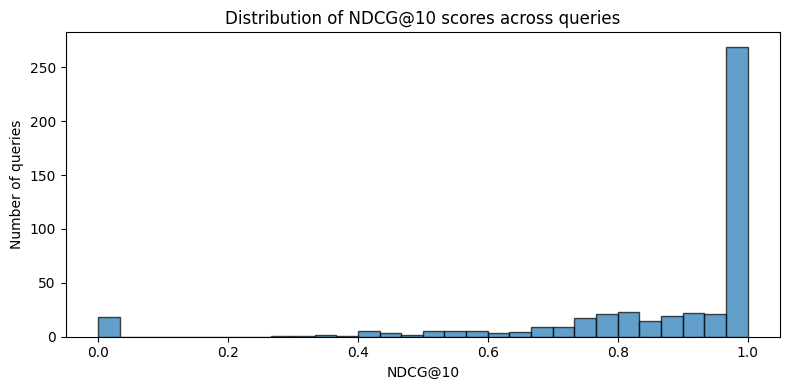

count    480.000000
mean       0.868163
std        0.225194
min        0.000000
25%        0.812411
50%        0.979461
75%        1.000000
max        1.000000
Name: ndcg, dtype: float64


In [35]:
# Task 5c: Analyze the distribution

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(eval_results["ndcg"], bins=30, edgecolor="black", alpha=0.7)
ax.set_xlabel("NDCG@10")
ax.set_ylabel("Number of queries")
ax.set_title("Distribution of NDCG@10 scores across queries")
plt.tight_layout()
plt.show()

# Summary stats
print(eval_results["ndcg"].describe())


---

## Task 6: Improve Search with Additional Fields

Our baseline only searches the `product_name` field. Let's improve by adding more fields!

### 6a. Index product_class field

The `product_class` field contains the category of the product (e.g., "Rugs", "Coffee Tables"). This is a powerful signal!

Create a search function that combines all three fields (name, description, class).

In [36]:
# Task 6a: Index product_class field

# 1. Build index for product_class (reuse index_name, index_desc from 3a/3b)
docs_class = products["product_class"].fillna("").astype(str).tolist()
index_class, doc_lengths_class = build_index(docs_class, snowball_tokenize)

# 2. Search function that combines name + description + class (sum of three BM25 scores)
def search_products_three(query: str, products_df: pd.DataFrame,
                          index_name: dict, doc_lengths_name: list,
                          index_desc: dict, doc_lengths_desc: list,
                          index_class: dict, doc_lengths_class: list,
                          tokenizer, k: int = 10) -> pd.DataFrame:
    n = len(products_df)
    scores_name = score_bm25(query, index_name, n, doc_lengths_name, tokenizer)
    scores_desc = score_bm25(query, index_desc, n, doc_lengths_desc, tokenizer)
    scores_class = score_bm25(query, index_class, n, doc_lengths_class, tokenizer)
    combined = scores_name + scores_desc + scores_class
    top_k_idx = np.argsort(-combined)[:k]
    results = products_df.iloc[top_k_idx].copy()
    results["score"] = combined[top_k_idx]
    results["rank"] = range(1, k + 1)
    return results

# 3. Sample search with all three fields
sample_query = "coffee table"
results_three = search_products_three(sample_query, products, index_name, doc_lengths_name,
                                     index_desc, doc_lengths_desc, index_class, doc_lengths_class,
                                     snowball_tokenize, k=10)
display(results_three[["rank", "product_name", "product_class", "score"]])


,rank,product_name,product_class,score
34496,1,picacho coffee table,Coffee & Cocktail Tables,21.260129
29952,2,metpally coffee table,Coffee & Cocktail Tables,20.946081
26857,3,elmcrest coffee table,Coffee & Cocktail Tables,20.834425
16877,4,mendivil coffee table,Coffee & Cocktail Tables,20.817171
38673,5,abdulsamet coffee table,Coffee & Cocktail Tables,20.817171
31403,6,hansmeier coffee table,Coffee & Cocktail Tables,20.765976
6344,7,huling coffee table,Coffee & Cocktail Tables,20.720970
22677,8,olive coffee table,Coffee & Cocktail Tables,20.711335
18381,9,eraman coffee table,Coffee & Cocktail Tables,20.665374
7185,10,norfolk coffee table,Coffee & Cocktail Tables,20.641140


### 6b. Evaluate three-field search

Now evaluate your three-field search on all queries to see how it compares to the baseline.

In [37]:
# Task 6b: Evaluate three-field search

# Search function using name + description + product_class
def search_fn_three(query: str, k: int = 10) -> pd.DataFrame:
    return search_products_three(query, products, index_name, doc_lengths_name,
                                 index_desc, doc_lengths_desc, index_class, doc_lengths_class,
                                 snowball_tokenize, k=k)

# Evaluate on all queries
eval_results_three = evaluate_search(search_fn_three, products, queries, labels, k=10, verbose=True)

# Compare to baseline (two-field: name + description from 5a)
mean_baseline = eval_results["ndcg"].mean()
mean_three = eval_results_three["ndcg"].mean()
print(f"\nBaseline (name + description) Mean NDCG@10: {mean_baseline:.4f}")
print(f"Three-field (name + description + class) Mean NDCG@10: {mean_three:.4f}")
print(f"Change: {mean_three - mean_baseline:+.4f}")


Evaluated 480 queries
Mean NDCG@10: 0.8791

Baseline (name + description) Mean NDCG@10: 0.8682
Three-field (name + description + class) Mean NDCG@10: 0.8791
Change: +0.0109


### 6c. Compare to baseline

Analyze which queries improved and which degraded when using three-field search.

In [38]:
# Task 6c: Compare to baseline

# Merge baseline and three-field results by query_id
compare = eval_results[["query_id", "query", "ndcg"]].merge(
    eval_results_three[["query_id", "ndcg"]], on="query_id", suffixes=("_baseline", "_three")
)
compare["ndcg_change"] = compare["ndcg_three"] - compare["ndcg_baseline"]

# Queries that improved most (positive change)
improved = compare.nlargest(10, "ndcg_change")
print("Top 10 queries that improved most with three-field search:")
display(improved)

# Queries that degraded most (negative change)
degraded = compare.nsmallest(10, "ndcg_change")
print("\nTop 10 queries that degraded most with three-field search:")
display(degraded)

# Summary counts
n_improved = (compare["ndcg_change"] > 0).sum()
n_degraded = (compare["ndcg_change"] < 0).sum()
n_unchanged = (compare["ndcg_change"] == 0).sum()
print(f"\nSummary: {n_improved} improved, {n_degraded} degraded, {n_unchanged} unchanged")


Top 10 queries that improved most with three-field search:


,query_id,query,ndcg_baseline,ndcg_three,ndcg_change
339,344,ottoman bed queen,0.000000,0.693426,0.693426
447,454,carpet 5x6,0.386853,0.955024,0.568171
240,244,pull out sleeper loveseat,0.000000,0.505128,0.505128
403,409,teal chair,0.000000,0.471628,0.471628
84,84,full metal bed rose gold,0.554827,0.996349,0.441522
387,393,propane gas dryer,0.523947,0.961309,0.437361
276,280,johan desk by laurel foundry,0.557448,0.910853,0.353405
21,21,living curtains pearl,0.618289,0.949389,0.331100
154,155,floating bed,0.422790,0.744648,0.321858
320,325,outdoor waterproof chest,0.421773,0.734818,0.313045



Top 10 queries that degraded most with three-field search:


,query_id,query,ndcg_baseline,ndcg_three,ndcg_change
304,309,moen 5995 arbor one,0.921787,0.289065,-0.632722
45,45,70s inspired furniture,0.583342,0.000000,-0.583342
42,42,toddler couch fold out,0.919721,0.468451,-0.451270
13,13,outdoor privacy wall,0.927414,0.500000,-0.427414
134,134,black hanging bookshelf,1.000000,0.630930,-0.369070
380,386,alter furniture,0.833213,0.489969,-0.343244
325,330,kari 2 piece,1.000000,0.659002,-0.340998
445,452,day bed indian,0.806574,0.500000,-0.306574
457,464,cake cutlery,0.978398,0.693030,-0.285368
397,403,wood rack wide,0.971164,0.710743,-0.260421



Summary: 131 improved, 97 degraded, 252 unchanged


---

## Task 7: Query Understanding with LLM

Sometimes users search for "star wars rug" when they really want a "rug with Star Wars theme". An LLM can help us understand what the user is actually looking for!

### 7a. Extract product type from query

Write a function using LiteLLM with structured outputs (Pydantic) to extract key information from a query.

In [39]:
# Task 7a: Extract product type, theme, material, color, and any other information you deem relevant from the query

class QueryExtraction(BaseModel):
    """Structured extraction of key information from a product search query."""
    product_type: Optional[str] = Field(None, description="Type of product (e.g. rug, coffee table, sofa, bookshelf)")
    theme: Optional[str] = Field(None, description="Theme or franchise (e.g. Star Wars, nautical)")
    material: Optional[str] = Field(None, description="Material (e.g. wooden, leather, metal)")
    color: Optional[str] = Field(None, description="Color (e.g. blue, white)")
    style: Optional[str] = Field(None, description="Style (e.g. modern, industrial)")
    other: Optional[str] = Field(None, description="Other relevant terms from the query")

def extract_query_info(query: str) -> QueryExtraction:
    """Use LLM to extract product type, theme, material, color, and other info from a search query."""
    prompt = f"""Extract key information from this furniture/home product search query. Return only the requested fields; use null for anything not mentioned.

Query: "{query}"

Extract: product_type (e.g. rug, table, sofa), theme (e.g. Star Wars), material (e.g. wood, leather, metal), color, style (e.g. modern), and any other relevant terms."""
    response = litellm.completion(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        response_format=QueryExtraction,
        max_tokens=200,
    )
    content = response.choices[0].message.content
    return QueryExtraction.model_validate_json(content)


In [40]:
# Test your query understanding function by running it against these test queries
test_queries = [
    "star wars rug",
    "wooden coffee table",
    "blue leather sofa",
    "modern metal bookshelf"
]

for q in test_queries:
    info = extract_query_info(q)
    print(f"Query: '{q}'")
    print(f"  -> {info.model_dump()}")
    print()

Query: 'star wars rug'
  -> {'product_type': 'rug', 'theme': 'Star Wars', 'material': None, 'color': None, 'style': None, 'other': None}

Query: 'wooden coffee table'
  -> {'product_type': 'coffee table', 'theme': None, 'material': 'wooden', 'color': None, 'style': None, 'other': None}

Query: 'blue leather sofa'
  -> {'product_type': 'sofa', 'theme': None, 'material': 'leather', 'color': 'blue', 'style': None, 'other': None}

Query: 'modern metal bookshelf'
  -> {'product_type': 'bookshelf', 'theme': None, 'material': 'metal', 'color': None, 'style': 'modern', 'other': None}



### 7b. Create an LLM-enhanced search

Use the extracted product type to boost matching results. If the LLM identifies "rug" as the product type, boost products where `product_class` contains "rug".

In [41]:
# Task 7b: Create an LLM-enhanced search

BOOST_VALUE = 3.0  # Add this to score when product_class matches extracted product_type
CANDIDATE_K = 50   # Get more candidates so boosting can re-rank before taking top k

def search_fn_llm(query: str, k: int = 10) -> pd.DataFrame:
    """Search using three-field BM25, then boost products whose product_class contains the LLM-extracted product type."""
    # 1. Get more candidates from three-field search
    candidates = search_products_three(query, products, index_name, doc_lengths_name,
                                       index_desc, doc_lengths_desc, index_class, doc_lengths_class,
                                       snowball_tokenize, k=CANDIDATE_K)
    # 2. Extract product type from query via LLM
    info = extract_query_info(query)
    product_type = (info.product_type or "").strip().lower()
    # 3. Boost scores where product_class contains product_type
    if product_type:
        class_match = candidates["product_class"].fillna("").astype(str).str.lower().str.contains(product_type, regex=False)
        candidates["boost"] = class_match.astype(float) * BOOST_VALUE
    else:
        candidates["boost"] = 0.0
    candidates["score_boosted"] = candidates["score"] + candidates["boost"]
    # 4. Re-rank by boosted score and return top k
    results = candidates.nlargest(k, "score_boosted").reset_index(drop=True)
    results["score"] = results["score_boosted"]
    results["rank"] = range(1, k + 1)
    out_cols = [c for c in results.columns if c not in ("boost", "score_boosted")]
    return results[out_cols]

# Optional: run a quick test (e.g. "star wars rug" should boost rugs)
sample = search_fn_llm("star wars rug", k=5)
display(sample[["rank", "product_name", "product_class", "score"]])


,rank,product_name,product_class,score
0,1,“ star wars - darth vader ” autographed framed...,Licensed Products|Wall Art,32.866691
1,2,star wars ep9 coffee mug,Licensed Products|Mugs & Teacups,32.434552
2,3,star wars dark side storage accent trunk,Licensed Products|Toy Boxes and Organizers,30.875370
3,4,star wars rule the galaxy rectangular pillow c...,Licensed Products|Accent Pillows,30.804444
4,5,star wars tie fighter 10 light string lights,Holiday Lighting|Licensed Products,29.464426


---
## Task 8: Submit via Pull Request

Now let's submit your work using the Git workflow from previous homeworks.
- [ ] Create a new branch called `homework-3`
- [ ] Commit you work and push it to the branch
- [ ] Create a PR with a nice description of your changes
- [ ] Merge the PR to your main branch
  
**The TA will verify your submission by checking the merged PR on your GitHub repo.**

**Also remember to submit your homework on Blackboard!**
